### Car Tracking project by Emil Wåreus


In [53]:

import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import time
from skimage.feature import hog 

## Extract Features


In [54]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [55]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
       
        features.append(hog_features)
        
        feature_image=cv2.flip(feature_image,1) 
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
       
        features.append(hog_features)
        
    # Return list of feature vectors
    return features
        

## Lets train a classifier!! 

In [83]:
#Load the data
import glob
cars = []
none_cars = []
for img in glob.glob('*data/non-vehicles/*/*.png'):
    none_cars.append(img)
    
    
for img in glob.glob("data/vehicles/*/*.png"):
    cars.append(img)


print("Number of cars : ", len(cars))
print("Number of none-cars : ", len(none_cars))

Number of cars :  8792
Number of none-cars :  8968


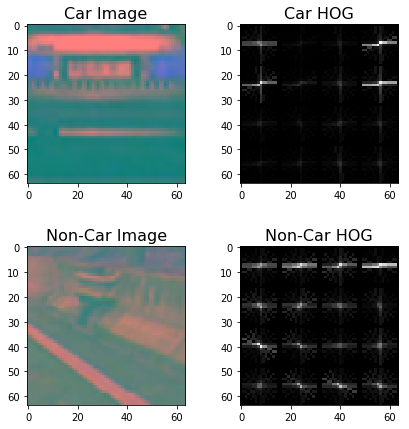

...


In [84]:
#Lets look at the features 
cspace = 'YUV' 
orient = 11
pix_per_cell = 16 
cell_per_block = 2 
hog_channel = 'ALL'

car_img = mpimg.imread(cars[5])
car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV)
_, car_dst = get_hog_features(car_img[:,:,2], 
                              orient, pix_per_cell, cell_per_block, 
                              vis=True, feature_vec=True)
noncar_img = mpimg.imread(none_cars[5])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YUV)
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 
                              orient, pix_per_cell, cell_per_block, 
                              vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.show()
print('...')

In [85]:
cspace = 'YUV' 
orient = 11
pix_per_cell = 16 
cell_per_block = 2 
hog_channel = 'ALL'


car_features = extract_features(cars, 
                                cspace=cspace, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)

none_car_features = extract_features(none_cars, 
                                cspace=cspace,
                                orient=orient, 
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)

print("Number of cars : ", len(car_features))
print("Number of none-cars : ", len(none_car_features))


Number of cars :  17584
Number of none-cars :  17936


In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import sklearn

print(len(car_features) + len(none_car_features))


SVC = LinearSVC() 
#Building a classifier:

X = np.vstack((car_features, none_car_features)).astype(np.float64)
print(len(X))

Y = np.hstack((np.ones(len(car_features)), np.zeros(len(none_car_features))))
print(len(Y))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22)
#print(len(scaled_X))
#train batch
SVC.fit(X_train, Y_train)
print(" Done")


35520
35520
35520
 Done


In [87]:
#Train support vector Machine
print("Accuracy of SVC : ", round(SVC.score(X_test, Y_test), 5))


Accuracy of SVC :  0.98297


## Sliding Window

In [88]:
#Finda car: 
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel , svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    #Cspace
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image) 
        
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            
            # Extract the image patch
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles




In [89]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


### Let's try it out! 

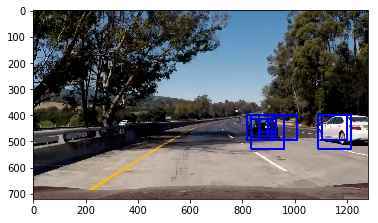

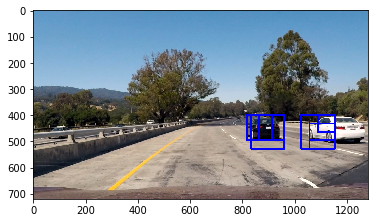

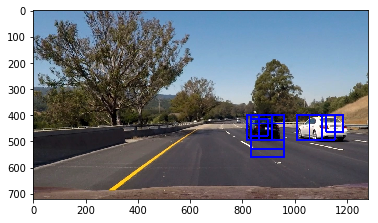

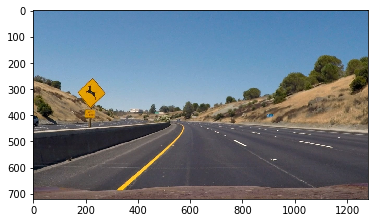

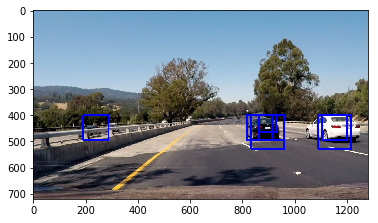

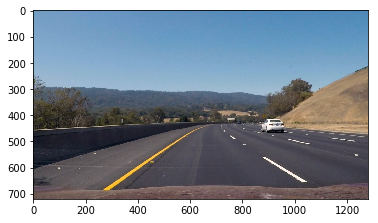

In [90]:
#After alot of itterations this combination was deemed good enough

def get_rect(img,cspace, hog_channel , SVC,
             X_scaler, orient, pix_per_cell, 
             cell_per_block):
    
    rectangles = []
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

    
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

   
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))
    ystart = 400
    ystop = 528
    scale = 2.0
    
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

    
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

    
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

   
    rectangles = [item for sublist in rectangles for item in sublist] 

    return rectangles


for image_path in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(image_path)
    img_out = img.copy()
    
    rectangles = get_rect(img, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)
    
    img_w_boxes = draw_boxes(img_out, rectangles, color = (255, 0 , 0), thick = 5)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB))
    plt.show()

### Testing the classifier 

Great! The classifier works okay. Now we need to add a heat map to get rid of the multiple classifications and false positives. We need to add some other scaling as well since the last image didn't classify correctly

In [100]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        size = np.absolute(np.max(nonzerox)-np.min(nonzerox))*np.absolute(np.min(nonzeroy)-np.max(nonzeroy))
        
        
        #Filter size of box! 
        if((size > 3000) &
          ((np.absolute(np.max(nonzerox)-np.min(nonzerox))
           /np.absolute(np.min(nonzeroy)-np.max(nonzeroy))) > 0.7 )):
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            
        
       
    # Return the image
    return img

    
def draw_heated_boxes(img, box_list, threshold = 2):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    
    return draw_labeled_bboxes(np.copy(img), labels)

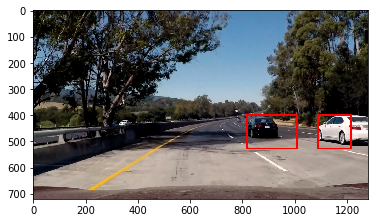

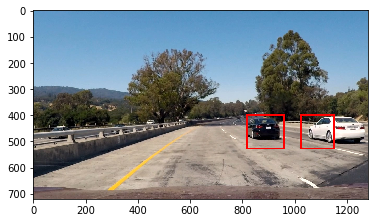

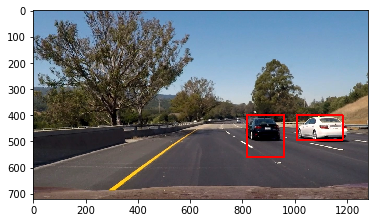

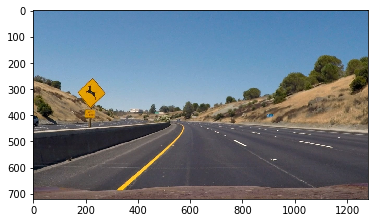

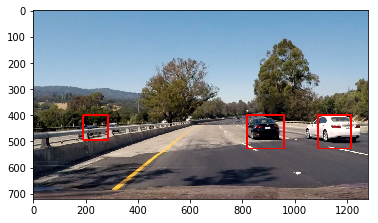

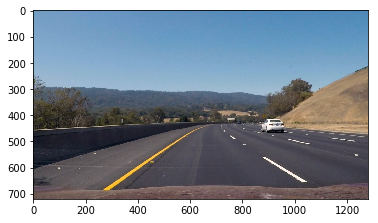

In [101]:
#Lets test with heat added:
i=1
for image_path in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(image_path)
    img_out = img.copy()
    
    rectangles = get_rect(img, cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)
  
    img_w_boxes = draw_heated_boxes(img_out, rectangles, threshold=0)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB))
    
    plt.show()
    path=('output_images/test_w_boxes{}.jpg'.format(i))
    cv2.imwrite(path,img)
    i = i+1

Good Enough! 

In [102]:
#Make Video: 
def full_pipeline(img):
    img_out = img.copy()
    
    rectangles = get_rect(img, cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)

    
    img_w_boxes = draw_heated_boxes(img_out, rectangles, threshold=1)
   
    return img_w_boxes

In [103]:
from moviepy.editor import VideoFileClip

output_v = 'project_video_proc_2.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(full_pipeline)
%time clip.write_videofile(output_v, audio=False)


[MoviePy] >>>> Building video project_video_proc_2.mp4
[MoviePy] Writing video project_video_proc_2.mp4



 12%|█▏        | 152/1261 [00:54<06:45,  2.74it/s]


 24%|██▍       | 303/1261 [01:49<05:58,  2.67it/s]


 36%|███▌      | 454/1261 [02:44<04:48,  2.79it/s]


 48%|████▊     | 605/1261 [03:38<03:52,  2.82it/s]


 60%|█████▉    | 756/1261 [04:32<03:05,  2.72it/s]


 72%|███████▏  | 907/1261 [05:27<02:12,  2.66it/s]


 84%|████████▍ | 1057/1261 [06:22<01:13,  2.79it/s]


 96%|█████████▌| 1205/1261 [07:16<00:20,  2.78it/s]


100%|█████████▉| 1260/1261 [07:36<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc_2.mp4 

CPU times: user 7min 40s, sys: 3.6 s, total: 7min 44s
Wall time: 7min 37s
